In [1]:
import os 
import sys
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np
from catboost import CatBoostClassifier, CatBoostRanker, Pool
from typing import List
sys.path.append('/Users/broniy/Desktop/creative')
%load_ext autoreload
%autoreload 2

In [2]:
clicked_df = pd.read_csv(
    "/Users/broniy/Desktop/CreativeRank/data/processed/clicked_variation_rows_v2.csv"
)
non_clicked_df = pd.read_csv(
    "/Users/broniy/Desktop/CreativeRank/data/processed/non_clicked_variation_rows.csv"
)
creative_feats = pd.read_csv(
    "/Users/broniy/Desktop/CreativeRank/data/processed/combined_feats.csv"
).rename(columns={"experiment_id": "EXPERIMENT_ID", "variation_id": "VARIATION_ID"})

In [5]:
variations_df = (
    creative_feats
    .drop(columns=["Unnamed: 0"])
    .fillna(
        value={
            "Q1": "UNK",
            "Q2": "UNK",
            "Q3": "UNK",
            "Q4": "UNK",
            "Q5": "UNK",
            "Q6": "UNK",
            "Q7": "UNK",
            "Q8": "UNK",
            "Q9": "UNK",
            "Q10": "UNK",
            "category": "UNK",
        }
    )
)
variations_df

,VARIATION_ID,image_name,EXPERIMENT_ID,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,subject_line,category
0,b5759954-f5df-4934-961e-e4f99bc01bf4,82ad5eff-31db-4c81-b861-3f0b01294229.jpg,76a8268a-d19b-49ee-9c3d-69cf86f9f0f9,Model,Studio,Social Proof / Validation,Unknown,Bra & Underwear,Studio,One,26-35,Curvy,Brown,We take care of you ❤️,Emotional appeal
1,f13b8f3a-28a4-45f6-8f5c-5344412cb3a3,38d2823a-98c1-462d-b77d-e4ea85c899f2.jpg,76a8268a-d19b-49ee-9c3d-69cf86f9f0f9,Model,Lifestyle,Promotional / Incentive,Unknown,Bra & Underwear,Bedroom / Home,One,26-35,Curvy,Brown,asdfa,Conversational tone
2,eb261cf6-c634-41cc-968b-06df59c49599,a5ec01be-d9c3-4399-a846-f4edfd8868be.jpg,14990f86-a9df-4861-a08a-433e9242860d,Model,Studio,Social Proof / Validation,Unknown,Bra & Underwear,Studio,One,26-35,Curvy,Brown,We take care of you ❤️,Emotional appeal
3,a43a50b5-5177-456e-b2dd-ea45272e3cd2,210c5779-41cc-490c-b94f-2cffe2a48732.jpg,14990f86-a9df-4861-a08a-433e9242860d,Model,UGC,Social Proof / Validation,Unknown,Bra & Underwear,Bedroom / Home,One,26-35,Curvy,Black,Bra Shopping Nightmares? Not Anymore.,Problem–solution
4,2889f0ae-360b-4419-b304-49da3283b22e,fd656e58-25bf-4669-8d91-f20f2d3905da.jpg,14990f86-a9df-4861-a08a-433e9242860d,Model,Lifestyle,Social Proof / Validation,Unknown,Bra & Underwear,Natural Light / Lifestyle,One,26-35,Curvy,Black,Bra Shopping? We Give You 6 Months.,Signature repetition
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,d33d584d-60a7-4b9d-8993-3d1b6786bc2d,6f142e2e-f2b5-4d7b-9f2d-ad017c619dd5.jpg,0ef6d2e9-7601-4df6-a215-83e6e79aa24e,Text,Unknown,Educational / Explanatory,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,UPDATE: Side Effects of Underoutfit ⚠️,Problem–solution
282,4eac4d70-7312-4a8a-8e8b-1f71747e0ec9,a5323a2e-b8a4-4218-861a-d82da1a35c1e.jpg,78a802ae-d6cd-4f39-aecb-138668fa2607,Model,Studio,Functional / Product-Focused,Shape & Silhouette,Bra,Studio,One,26-35,Slim,White,Every mom deserves this!,Emotional appeal
283,0dd3bab1-19bb-472b-93cd-038103dde79e,d409a3ce-1185-41f3-8718-154e3774512f.jpg,78a802ae-d6cd-4f39-aecb-138668fa2607,Model,Lifestyle,Functional / Product-Focused,Fit & Support,Bra,Everyday Lifestyle,One,26-35,Slim,White,"Real women, Real lift - Comfort you’ll love 💃",Sensory / lifestyle
284,637fdd90-26ed-42aa-affd-b27e5955b4a4,2fad7ea1-86ef-4c22-8b79-7bf9298f5de8.jpg,0ef6d2e9-7601-4df6-a215-83e6e79aa24e,Text,UGC,Educational / Explanatory,Unknown,Unknown,Unknown,Two,Unknown,Unknown,Unknown,UPDATE: underoutfit is contagious ⚠️,Conversational tone


In [6]:
users_df = (
    pd.concat([clicked_df, non_clicked_df], axis=0)
    .assign(
        CLICK=lambda x: (x["CLICK_COUNT"] > 0).astype(int),
        EXPERIMENT_DATE=lambda x: pd.to_datetime(
            {
                "year": 2025,
                "month": x["MONTH"],
                "day": x["DAY"],
            }
        ),
    )
    .dropna(subset=["CLICK_COUNT"])
    .drop(columns=["RN"])
    .fillna(
        value={
            "TOTAL_ORDERS_VALUE": 0,
            "AVG_ORDER_VALUE": 0,
            "LAST_ORDER_VALUE": 0,
            "COUNTRY": "UNK",
            "REGION": "UNK",
            "LATEST_CLICK_CLIENT_TYPE": "UNK",
            "LATEST_CLICK_CLIENT_NAME": "UNK",
            "LATEST_CLICK_CLIENT_OS_FAMILY": "UNK",
            "FIRST_UTM_SOURCE": "UNK",
            "FIRST_UTM_CONTENT": "UNK",
            "FIRST_UTM_CAMPAIGN": "UNK",
            "CITY": "UNK",
            "TIMEZONE": "UNK",
        }
    )
)
# Convert FIRST_ACTIVE_TS to datetime
users_df["FIRST_ACTIVE_TS_dt"] = pd.to_datetime(users_df["FIRST_ACTIVE_TS"])

# Compute months between today and FIRST_ACTIVE_TS
today = pd.Timestamp(datetime.today())

# Compute years and months difference and convert to total months
users_df["MONTHS_SINCE_FIRST_ACTIVE"] = (
    today.year - users_df["FIRST_ACTIVE_TS_dt"].dt.year
) * 12 + (today.month - users_df["FIRST_ACTIVE_TS_dt"].dt.month)

users_df = users_df[users_df["VARIATION_ID"].isin(variations_df["VARIATION_ID"])]
users_df = users_df.drop_duplicates()

In [7]:
variations_per_experiment = (
    users_df[["EXPERIMENT_ID", "VARIATION_ID"]]
    .drop_duplicates()
)
variations_per_experiment

,EXPERIMENT_ID,VARIATION_ID
0,43d750b5-8698-4cf0-9ea2-f705f4f196ed,869cd96a-2cf5-46e7-9c65-db5088bb335a
1,81ae4870-e57d-4bc4-a2d7-48ffa5411707,99e778d6-f7a3-404f-8abb-9f9027be9598
2,43d750b5-8698-4cf0-9ea2-f705f4f196ed,a472cd3a-d719-4a99-bb89-7ba8a2e0e84c
3,e627d7f0-46c4-4894-872e-59a2fc108c30,0fbe8e48-16a7-46bf-88eb-0347190a7e6d
4,49c33d7c-ef04-43a7-bbd0-783489c64849,2dd79b7f-a399-459e-8eb0-6baf3a22f53b
...,...,...
6997,643fa7cf-eb96-4a76-bed4-cacaee4d1d72,4a7bbaff-0e2c-4467-982e-086f93b71f63
12546,643fa7cf-eb96-4a76-bed4-cacaee4d1d72,e912bd67-a689-44b6-9fd7-5ba12ad055b6
22875,643fa7cf-eb96-4a76-bed4-cacaee4d1d72,91137d04-8dc4-4f11-bd81-1b4090a5766c
24610,21db3b9d-47b2-4eb0-b941-376c6fe54ad6,86849095-5dd3-4b5c-b92f-88b85549f819


In [8]:
# Print the size of users_df before removal
print(f"users_df size before removing small experiments: {users_df.shape[0]} rows")
# Remove experiments with less than 100 participants
experiment_counts = users_df.groupby("EXPERIMENT_ID")["RECIPIENT_ID"].nunique()
valid_experiments = experiment_counts[experiment_counts >= 100].index
users_df = users_df[users_df["EXPERIMENT_ID"].isin(valid_experiments)]
# Print the size of users_df after removal
print(f"users_df size after removing small experiments: {users_df.shape[0]} rows")


users_df size before removing small experiments: 93873 rows
users_df size after removing small experiments: 93831 rows


In [9]:
users_df.sort_values("EXPERIMENT_DATE").groupby(["EXPERIMENT_ID", "EXPERIMENT_DATE"]).agg({"RECIPIENT_ID": "nunique"})

,,RECIPIENT_ID
EXPERIMENT_ID,EXPERIMENT_DATE,
002deaf7-331f-4b5e-866b-f6dad60e4a79,2025-07-28,2710
00bb26ff-6fe3-4465-ac77-12bfc33aa6df,2025-07-17,3574
0ef6d2e9-7601-4df6-a215-83e6e79aa24e,2025-10-06,2586
11c49e5d-21ac-4d6d-88c3-f211562a8e07,2025-09-17,2304
1d6dbba7-dcc5-46f4-a4aa-aef3124a8fcf,2025-09-05,3918
2a3f341e-1807-4eb3-9d8d-202c32d52632,2025-08-25,2150
3ecf34fc-1f15-4b32-970f-4061544da763,2025-07-14,3670
43d750b5-8698-4cf0-9ea2-f705f4f196ed,2025-09-25,3924
44d26695-cdf2-41a4-b161-393fdaf964bc,2025-07-26,4244


In [10]:
users_df.groupby(["EXPERIMENT_ID", "EXPERIMENT_DATE"]).agg({"CLICK": ["sum", "count"]})

CLICK      
                                                       sum count
EXPERIMENT_ID                        EXPERIMENT_DATE            
002deaf7-331f-4b5e-866b-f6dad60e4a79 2025-07-28       1355  2710
00bb26ff-6fe3-4465-ac77-12bfc33aa6df 2025-07-17       1787  3574
0ef6d2e9-7601-4df6-a215-83e6e79aa24e 2025-10-06       1293  2586
11c49e5d-21ac-4d6d-88c3-f211562a8e07 2025-09-17       1156  2305
1d6dbba7-dcc5-46f4-a4aa-aef3124a8fcf 2025-09-05       1959  3918
2a3f341e-1807-4eb3-9d8d-202c32d52632 2025-08-25       1075  2150
3ecf34fc-1f15-4b32-970f-4061544da763 2025-07-14       1835  3670
43d750b5-8698-4cf0-9ea2-f705f4f196ed 2025-09-25       1968  3928
44d26695-cdf2-41a4-b161-393fdaf964bc 2025-07-26       2122  4244
49c33d7c-ef04-43a7-bbd0-783489c64849 2025-09-06       1757  3514
6a258715-721a-41e9-8abb-af41308c1f48 2025-08-19       2051  4102
6f506df9-be60-452d-b914-8230c29c2ff1 2025-07-22       1622  3243
78a802ae-d6cd-4f39-aecb-138668fa2607 2025-10-02       1139  2278
81ae4870-e57d-4bc4-a2d7-48ffa5411707 2025-07-10       2113  4226
823158da-7b0a-4c19-8189-663c22a3ae38 2025-09-27       2286  4572
8ea67496-0fb3-4efd-8cea-4b8d88351b8e 2025-07-01       1766  2711
91eee220-fee7-488b-952a-c96aa8e493db 2025-08-14       1627  3254
9cd54b2b-31f9-43e4-9073-0d2b61bf9f15 2025-08-30       2039  4078
9defe9fd-0374-4de6-99f7-aaa392903d67 2025-08-12       2244  4488
a1db5d4b-b641-4d3d-a8a6-d4c9bdd9c033 2025-08-23       1543  3086
c5288ca2-3928-4364-8f08-bebc1036dd87 2025-07-11       2626  5252
cd4a656f-290a-41e2-be1d-bf62ad85757d 2025-09-29       2186  4368
e4b4a349-3b14-439e-946f-f716101dac69 2025-08-02        853  1704
e627d7f0-46c4-4894-872e-59a2fc108c30 2025-08-07        356   679
e697ab50-0abb-42d3-92a0-43f1ed597476 2025-08-29       3678  7356
f93bf2bd-1d50-4131-9ec2-223a4d9987e8 2025-09-23       2921  5835

In [11]:
USER_COLS = [
    "RECIPIENT_ID",
    "COUNTRY",
    "REGION",
    "LATEST_CLICK_CLIENT_TYPE",
    "LATEST_CLICK_CLIENT_NAME",
    "LATEST_CLICK_CLIENT_OS_FAMILY",
    "TOTAL_ORDERS_VALUE",
    "AVG_ORDER_VALUE",
    "LAST_ORDER_VALUE",
    "MONTHS_SINCE_FIRST_ACTIVE",
    "CLICK",
    "FIRST_UTM_SOURCE",
    "FIRST_UTM_CONTENT",
    "FIRST_UTM_CAMPAIGN",
    "CITY",
    "TIMEZONE"
]
VARIATION_COLS = [
    "Q1",
    "Q2",
    "Q3",
    "Q4",
    "Q5",
    "Q6",
    "Q7",
    "Q8",
    "Q9",
    "Q10",
    "category"
]

CATEGORICAL_COLS = [
    "COUNTRY",
    "REGION",
    "CITY",
    "TIMEZONE",
    "LATEST_CLICK_CLIENT_TYPE",
    "LATEST_CLICK_CLIENT_NAME",
    "LATEST_CLICK_CLIENT_OS_FAMILY",
    "FIRST_UTM_SOURCE",
    "FIRST_UTM_CONTENT",
    "FIRST_UTM_CAMPAIGN",
    "Q1",
    "Q2",
    "Q3",
    "Q4",
    "Q5",
    "Q6",
    "Q7",
    "Q8",
    "Q9",
    "Q10",
    "category"
]

NUMERICAL_COLS = [
    "TOTAL_ORDERS_VALUE",
    "AVG_ORDER_VALUE",
    "LAST_ORDER_VALUE",
    "MONTHS_SINCE_FIRST_ACTIVE"
]
COLS = CATEGORICAL_COLS + NUMERICAL_COLS

In [94]:
def get_pooled_dataset(data_df: pd.DataFrame):
    data_df_sorted = data_df.sort_values(["EXPERIMENT_ID", "RECIPIENT_ID"])
    group_ids = (
        data_df_sorted[["EXPERIMENT_ID", "RECIPIENT_ID"]]
        .astype(str)
        .agg("_".join, axis=1)
        .astype("category").cat.codes.values
    )
    X, y = data_df_sorted[COLS], data_df_sorted["CLICK"]
    cat_features = [
        X.columns.get_loc(col) for col in CATEGORICAL_COLS if col in X.columns
    ]
   
    pool = Pool(
        X, label=y, cat_features=cat_features, group_id=group_ids
    )
    return pool, group_ids, X, y

### Metrics

In [13]:
def hit_rate_at_k(preds: pd.DataFrame, y_true: pd.DataFrame, k: int):
    top_k_preds = (
        preds
        .sort_values(
            ["EXPERIMENT_ID", "RECIPIENT_ID", "PRED"], ascending=[True, True, False]
        )
        .groupby(["EXPERIMENT_ID", "RECIPIENT_ID"])
        .head(k)
        
    )
    # Merge y_true with top_k_preds to find hits
    hits = pd.merge(
        y_true,
        top_k_preds,
        on=["EXPERIMENT_ID", "RECIPIENT_ID", "VARIATION_ID"],
        how="inner"
    )
    # Calculate hit rate per experiment
    total_per_experiment = y_true.groupby("EXPERIMENT_ID").size()
    hits_per_experiment = hits.groupby("EXPERIMENT_ID").size()
    # Fill missing experiments (with no hits) with 0
    hits_per_experiment = hits_per_experiment.reindex(total_per_experiment.index, fill_value=0)
    hit_rate_per_experiment = hits_per_experiment / total_per_experiment
    
    test_variations_per_experiment = preds.groupby("EXPERIMENT_ID")["VARIATION_ID"].nunique()
    base_hit_rate = 1 / test_variations_per_experiment
    uplift_hit_rate = (hit_rate_per_experiment - base_hit_rate) / base_hit_rate * 100
    
    # Return mean hit rate over all experiments
    return hit_rate_per_experiment.mean(), uplift_hit_rate.mean()

def mrr_at_k(preds: pd.DataFrame, y_true: pd.DataFrame, k: int):
    """
    Compute mean reciprocal rank (MRR) at k for each experiment,
    and return the mean MRR across all experiments.
    """
    # Sort and get top k per EXPERIMENT_ID, RECIPIENT_ID
    preds_sorted = (
        preds
        .sort_values(["EXPERIMENT_ID", "RECIPIENT_ID", "PRED"], ascending=[True, True, False])
        .groupby(["EXPERIMENT_ID", "RECIPIENT_ID"])
        .head(k)
    )

    # Compute rank for each RECIPIENT_ID in each EXPERIMENT_ID
    preds_sorted["RANK"] = preds_sorted.groupby(["EXPERIMENT_ID", "RECIPIENT_ID"]).cumcount() + 1

    # Only keep relevant columns for merge
    temp = preds_sorted[["EXPERIMENT_ID", "RECIPIENT_ID", "VARIATION_ID", "RANK"]]

    # Join with y_true (ground truth click) to get the relevant rank for each true event
    gt_ranks = pd.merge(
        y_true[["EXPERIMENT_ID", "RECIPIENT_ID", "VARIATION_ID"]],
        temp,
        on=["EXPERIMENT_ID", "RECIPIENT_ID", "VARIATION_ID"],
        how="left"
    )

    # Rank will be nan if not in top-k
    gt_ranks["RECIPROCAL_RANK"] = gt_ranks["RANK"].apply(lambda x: 1 / x if pd.notnull(x) else 0)

    # Compute mean MRR for each experiment
    mrr_per_experiment = gt_ranks.groupby("EXPERIMENT_ID")["RECIPROCAL_RANK"].mean()

    mrr_base = preds.groupby(["EXPERIMENT_ID"])["VARIATION_ID"].nunique().apply(lambda x: sum(1/i for i in range(1, x + 1))/x if x > 0 else 0)
    uplift_mrr = (mrr_per_experiment - mrr_base) / mrr_base * 100
    # Return the mean across all experiments (or you could return the per-experiment series)
    return mrr_per_experiment.mean(), uplift_mrr.mean()

### Models

In [129]:
def get_model(type: str, cat_features: List[int]):
    if type == "catboost":
        model = CatBoostClassifier(
            iterations=1000,
            learning_rate=0.03,
            depth=6,
            loss_function="Logloss",
            eval_metric="AUC",
            cat_features=cat_features,
            random_seed=42,
            verbose=100,
            # early_stopping_rounds=500,
            use_best_model=True,
        )
        return model
    elif type == "ranker":
        model = CatBoostRanker(
            iterations=2000,
            learning_rate=0.015,
            depth=10,
            loss_function="YetiRank",
            cat_features=cat_features,
            random_seed=42,
            verbose=False,
            eval_metric="MRR",
            early_stopping_rounds=500,
        )
        return model

### Classification results

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

# Ensure experiment_date is datetime
users_df["EXPERIMENT_DATE"] = pd.to_datetime(users_df["EXPERIMENT_DATE"])

# Sort unique experiments by date
experiment_order = (
    users_df[["EXPERIMENT_ID", "EXPERIMENT_DATE"]]
    .sort_values("EXPERIMENT_DATE")
    .drop_duplicates()
    .reset_index(drop=True)
)
# Get last two for test, others for train
test_experiments = experiment_order.tail(2)["EXPERIMENT_ID"]
train_experiments = experiment_order.iloc[:-2]["EXPERIMENT_ID"]

# Join users_df with variation_df on EXPERIMENT_ID and VARIATION_ID
merged_df = users_df.merge(
    variations_df,
    left_on=["EXPERIMENT_ID", "VARIATION_ID"],
    right_on=["EXPERIMENT_ID", "VARIATION_ID"],
    how="left"
)

# Select rows for train/test
train_df = merged_df[merged_df["EXPERIMENT_ID"].isin(train_experiments)]
test_df= merged_df[merged_df["EXPERIMENT_ID"].isin(test_experiments)]
print(len(train_df), len(test_df))

display(merged_df.head())
X_train = train_df[ COLS]
y_train = train_df[ "CLICK"]
X_test = test_df[COLS]
y_test = test_df[ "CLICK"]

# Identify categorical features indices for CatBoost
cat_features = [X_train.columns.get_loc(col) for col in CATEGORICAL_COLS if col in X_train.columns]

clf = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    cat_features=cat_features,
    random_seed=42,
    verbose=100,
    # early_stopping_rounds=500,
    use_best_model=True
)
clf.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# If you want to report AUC on test:
from sklearn.metrics import roc_auc_score
y_pred = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
print(f"Test AUC: {auc:.4f}")
print(f"Best validation score: {clf.best_score_['validation']['AUC']:.4f}")


group_ids: [    0     0     0 ... 80014 80014 80014]
y: 20461    0.5
20462    1.0
20463    0.5
20464    0.5
20465    0.5
        ... 
73488    0.5
73489    0.5
73490    0.5
73491    1.0
73492    0.5
Name: CLICK, Length: 398431, dtype: float64
[0.6   0.4   0.3   0.375 0.625]


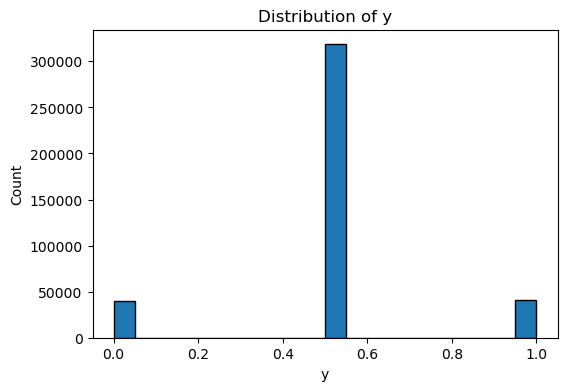

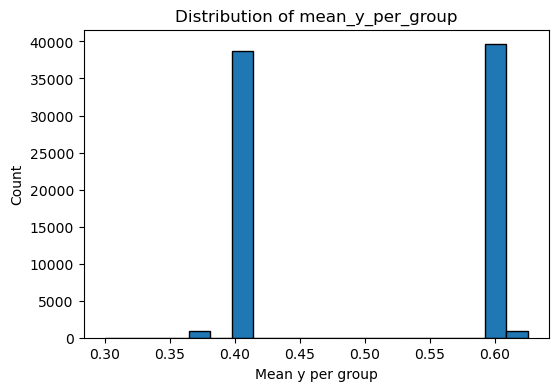

In [74]:
train_pool, group_ids, y = get_pooled_dataset(train_df)
print(f'group_ids: {group_ids}')
print(f'y: {y}')
import pandas as pd

# group_ids is assumed to align with y: each group corresponds to a slice of y (e.g., lengths)
# But if group_ids is just a Series (not group sizes), groupby works directly.

# If group_ids is an array of group IDs per row in y:
mean_y_per_group = pd.DataFrame({"group_id": group_ids, "y": y}).groupby("group_id")["y"].mean()
print(mean_y_per_group.unique())

import matplotlib.pyplot as plt

# Show the distribution of y (target)
plt.figure(figsize=(6,4))
plt.hist(y, bins=20, edgecolor='k')
plt.title("Distribution of y")
plt.xlabel("y")
plt.ylabel("Count")
plt.show()

# Show the distribution of mean_y_per_group
plt.figure(figsize=(6,4))
plt.hist(mean_y_per_group, bins=20, edgecolor='k')
plt.title("Distribution of mean_y_per_group")
plt.xlabel("Mean y per group")
plt.ylabel("Count")
plt.show()


### Ranking Results

In [114]:
# Ensure experiment_date is datetime
users_df["EXPERIMENT_DATE"] = pd.to_datetime(users_df["EXPERIMENT_DATE"])

# Sort unique experiments by date
experiment_order = (
    users_df[["EXPERIMENT_ID", "EXPERIMENT_DATE"]]
    .sort_values("EXPERIMENT_DATE")
    .drop_duplicates()
    .reset_index(drop=True)
)
# Get last two for test, others for train
test_experiments = experiment_order.tail(2)["EXPERIMENT_ID"]
val_experiments = experiment_order.iloc[-4:-2]["EXPERIMENT_ID"]
train_experiments = experiment_order.iloc[:-4]["EXPERIMENT_ID"]

# Join users_df with variation_df on EXPERIMENT_ID and VARIATION_ID


users_all_variations = pd.merge(
    users_df.drop(columns=["VARIATION_ID"]),
    variations_per_experiment,
    how="left",
    left_on="EXPERIMENT_ID",
    right_on="EXPERIMENT_ID",
)
# Assign the click to the correct variation
users_all_variations["CLICK"] = users_all_variations.set_index(
    ["EXPERIMENT_ID", "RECIPIENT_ID", "VARIATION_ID"]
).index.map(
    users_df.set_index(["EXPERIMENT_ID", "RECIPIENT_ID", "VARIATION_ID"])["CLICK"]
).fillna(0.5)


users_all_variations = users_all_variations.merge(
    variations_df,
    left_on=["EXPERIMENT_ID", "VARIATION_ID"],
    right_on=["EXPERIMENT_ID", "VARIATION_ID"],
    how="left",
)


# Select rows for train/test
train_df = users_all_variations[users_all_variations["EXPERIMENT_ID"].isin(train_experiments)]
# For validation set
val_df_raw = users_all_variations[users_all_variations["EXPERIMENT_ID"].isin(val_experiments)]
val_df = (
    val_df_raw.groupby(["EXPERIMENT_ID", "RECIPIENT_ID"])
    .filter(lambda g: g["CLICK"].max() == 1)
)

# For test set
test_df_raw = users_all_variations[users_all_variations["EXPERIMENT_ID"].isin(test_experiments)]
test_df = (
    test_df_raw.groupby(["EXPERIMENT_ID", "RECIPIENT_ID"])
    .filter(lambda g: g["CLICK"].max() == 1)
)

train_pool, _, X_train, y_train = get_pooled_dataset(train_df)
val_pool, _, X_val, y_val = get_pooled_dataset(val_df)
cat_features = train_pool.get_cat_feature_indices()

ranker = get_model("ranker", cat_features)
ranker.fit(train_pool, eval_set=val_pool, use_best_model=True)

Groupwise loss function. OneHotMaxSize set to 10
0:	learn: 0.3050726	test: 0.2000000	best: 0.2000000 (0)	total: 365ms	remaining: 12m 9s
1:	learn: 0.3203543	test: 0.2000000	best: 0.2000000 (0)	total: 606ms	remaining: 10m 5s
2:	learn: 0.3207242	test: 0.2000000	best: 0.2000000 (0)	total: 882ms	remaining: 9m 46s
3:	learn: 0.3278356	test: 0.2486136	best: 0.2486136 (3)	total: 1.13s	remaining: 9m 23s
4:	learn: 0.3324450	test: 0.2932245	best: 0.2932245 (4)	total: 1.43s	remaining: 9m 32s
5:	learn: 0.3449076	test: 0.3281790	best: 0.3281790 (5)	total: 1.68s	remaining: 9m 18s
6:	learn: 0.3449364	test: 0.3281790	best: 0.3281790 (5)	total: 1.98s	remaining: 9m 24s
7:	learn: 0.3445644	test: 0.3281790	best: 0.3281790 (5)	total: 2.22s	remaining: 9m 13s
8:	learn: 0.3448378	test: 0.3281790	best: 0.3281790 (5)	total: 2.42s	remaining: 8m 54s
9:	learn: 0.3451482	test: 0.3281790	best: 0.3281790 (5)	total: 2.65s	remaining: 8m 48s
10:	learn: 0.3455050	test: 0.3281790	best: 0.3281790 (5)	total: 2.89s	remaining: 

In [124]:
test_pool, test_group_ids, X_test, y_test = get_pooled_dataset(val_df)
scores = ranker.predict(X_test)

In [125]:
preds = val_df.sort_values(["EXPERIMENT_ID", "RECIPIENT_ID"]).assign(
    PRED=scores, GT=y_test
)[["EXPERIMENT_ID", "RECIPIENT_ID", "VARIATION_ID", "PRED"]]
y_true = val_df[["EXPERIMENT_ID", "RECIPIENT_ID", "VARIATION_ID", "CLICK"]].query("CLICK==1")
mrr_at_k(preds, y_true, 5)

(np.float64(0.46327605854696646), np.float64(1.4473120905765984))

### Train catboost via expanding window approach

In [130]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5, test_size=5)
idx = (
    users_df[["EXPERIMENT_ID", "EXPERIMENT_DATE"]]
    .sort_values("EXPERIMENT_DATE")
    .drop_duplicates()
    .reset_index(drop=True)
)

hit_rate_results = []
uplift_hit_rate_results = []
mrr_results = []
uplift_mrr_results = []

users_all_variations = pd.merge(
    users_df.drop(columns=["VARIATION_ID"]),
    variations_per_experiment,
    how="left",
    left_on="EXPERIMENT_ID",
    right_on="EXPERIMENT_ID",
)
# Assign the click to the correct variation
users_all_variations["CLICK"] = (
    users_all_variations.set_index(["EXPERIMENT_ID", "RECIPIENT_ID", "VARIATION_ID"])
    .index.map(
        users_df.set_index(["EXPERIMENT_ID", "RECIPIENT_ID", "VARIATION_ID"])["CLICK"]
    )
    .fillna(0.5)
)

users_all_variations = users_all_variations.merge(
    variations_df,
    left_on=["EXPERIMENT_ID", "VARIATION_ID"],
    right_on=["EXPERIMENT_ID", "VARIATION_ID"],
    how="left",
)

for train_idx, test_idx in tscv.split(idx):
    print(f"Train idx: {train_idx}, Test idx: {test_idx}")
    train_idx = idx.iloc[train_idx]["EXPERIMENT_ID"].values
    test_idx = idx.iloc[test_idx]["EXPERIMENT_ID"].values

    # prepare train data
    
    train_df = users_all_variations[users_all_variations["EXPERIMENT_ID"].isin(train_idx)]


    train_pool, _, X_train, y_train = get_pooled_dataset(train_df)

    # prepare test data
    test_df_raw = users_all_variations[users_all_variations["EXPERIMENT_ID"].isin(test_idx)]
    test_df = (
        test_df_raw.groupby(["EXPERIMENT_ID", "RECIPIENT_ID"])
        .filter(lambda g: g["CLICK"].max() == 1)
    )

    test_pool, test_group_ids, X_test, y_test = get_pooled_dataset(test_df)
    cat_features = train_pool.get_cat_feature_indices()

    # Train CatBoost model

    print("Training CatBoost model...")
    model = get_model("ranker", cat_features)
    model.fit(train_pool)

    scores = ranker.predict(X_test)
    preds = test_df.sort_values(["EXPERIMENT_ID", "RECIPIENT_ID"]).assign(
        PRED=scores, GT=y_test
    )[["EXPERIMENT_ID", "RECIPIENT_ID", "VARIATION_ID", "PRED"]]
    y_true = test_df[["EXPERIMENT_ID", "RECIPIENT_ID", "VARIATION_ID", "CLICK"]].query(
        "CLICK==1"
    )


    hit_rate, uplift_hit_rate = hit_rate_at_k(preds, y_true, k=1)
    mrr, uplift_mrr = mrr_at_k(preds, y_true, 5)

    hit_rate_results.append(hit_rate)
    uplift_hit_rate_results.append(uplift_hit_rate)
    mrr_results.append(mrr)
    uplift_mrr_results.append(uplift_mrr)

    print(
        "hit_rate:",
        hit_rate,
        "uplift_hit_rate:",
        uplift_hit_rate,
        "mrr:",
        mrr,
        "uplift_mrr:",
        uplift_mrr,
    )

    # test_data = users_df.set_index(["EXPERIMENT_ID"]).loc[test_idx]
    # train_data = (users_df[users_df["RECIPIENT_ID"].isin(recipient_ids[train_idx])][USER_COLS]
    #     .join(variations_df[["EXPERIMENT_ID", "VARIATION_ID"]], on="EXPERIMENT_ID")
    # )
    # test_data = users_df.loc[recipient_ids[test_idx]]

    # train_X, train_y = train_data[cols], train_data["CLICK"]
    # test_X, test_y = test_data[cols], test_data["CLICK"]

Train idx: [0], Test idx: [1 2 3 4 5]
Training CatBoost model...
hit_rate: 0.15239005209650938 uplift_hit_rate: -23.804973951745318 mrr: 0.41075715120591705 uplift_mrr: -10.053178568047361
Train idx: [0 1 2 3 4 5], Test idx: [ 6  7  8  9 10]
Training CatBoost model...
hit_rate: 0.20985625710279784 uplift_hit_rate: 1.1532164763696227 mrr: 0.4671090856014537 uplift_mrr: -0.22665645047364585
Train idx: [ 0  1  2  3  4  5  6  7  8  9 10], Test idx: [11 12 13 14 15]
Training CatBoost model...
hit_rate: 0.20736489276734957 uplift_hit_rate: 3.6824463836747916 mrr: 0.462936710845825 uplift_mrr: 1.3730023749981741
Train idx: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15], Test idx: [16 17 18 19 20]
Training CatBoost model...
hit_rate: 0.21727091020157988 uplift_hit_rate: 8.635455100789931 mrr: 0.4714695218050221 uplift_mrr: 3.2415011251873254
Train idx: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20], Test idx: [21 22 23 24 25]
Training CatBoost model...
hit_rate: 0.23273796

In [40]:
model.predict_proba(test_X.iloc[:4])

array([[0.64432021, 0.35567979],
       [0.64685477, 0.35314523],
       [0.61760345, 0.38239655],
       [0.6151529 , 0.3848471 ]])

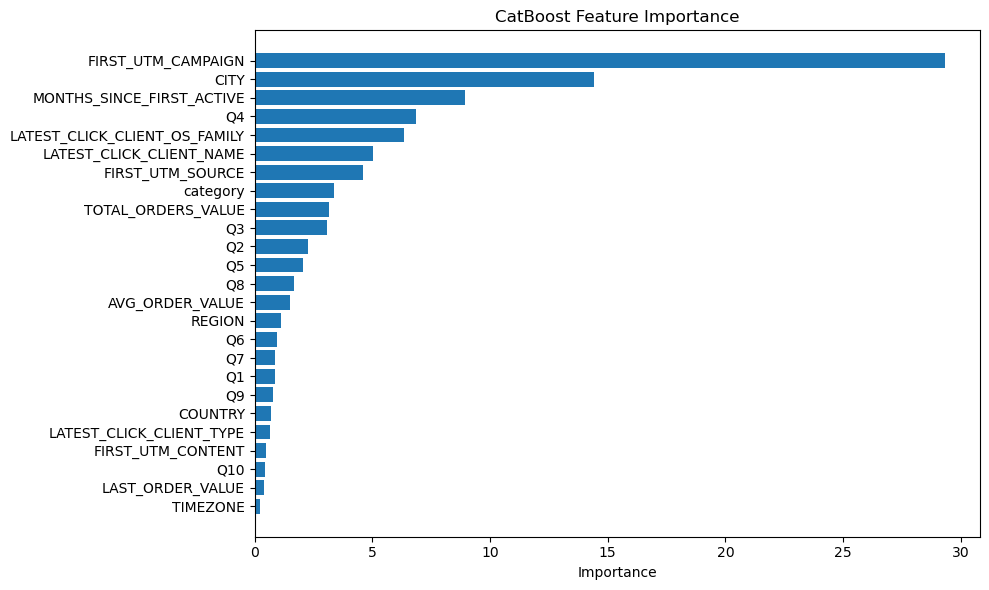

In [ ]:
import matplotlib.pyplot as plt

# Plot feature importance
feature_importances = model.get_feature_importance()
feature_names = list(train_X.columns)

# Sort feature importances and names in ascending order
sorted_indices = feature_importances.argsort()
sorted_importances = feature_importances[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel('Importance')
plt.title('CatBoost Feature Importance')
plt.tight_layout()
plt.show()
